# Route Identification Over Time, Approach 1

Recent observations shows small chages in routes over time. Specifically in the following fields:
* route ID
* route short name
* route long name
* route desc

Need to observe these route changes in order to account for these changes in future analyses.

## Objective
1. Query data from `fct_monthly_routes` to help identify variences in Routes. Query for 2023, a couple of months. 
2. Save data to GCS `gtfs_schedule` bucket
3. Filter down data to `Sacramento Regional Transit`, identify and observe routes for any variences


In [40]:
#imports copied from download_vehicle_position.py script

import datetime
import gcsfs
import geopandas as gpd
import pandas as pd
import shapely
import sys

from calitp_data_analysis.tables import tbls
from calitp_data_analysis import utils
from loguru import logger
from siuba import *

from shared_utils import schedule_rt_utils
from shared_utils import geography_utils



In [52]:
# test to query fct_monthly_routes. DO NOT RUN

def get_monthly_routes(
        year: str,
        months: list
    ) -> pd.DataFrame:    
    
        df = (tbls.mart_gtfs.fct_monthly_routes()
              >> filter(_.year == year)
              >> filter(_.month.isin(months))
              >> select(_.key, _.source_record_id,
                        _.name,
                        _.route_id, _.shape_id,
                        _.month,
                        _.year,
                       _.pt_array)
                  >> collect()
             )
        return df

In [53]:
 df_pt = get_monthly_routes(2023, [4, 5, 6, 7, 8, 9])

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
  sqlalchemy.util.warn(


In [55]:
#from metabase, joined fct_monthly_routes with dim_providers_gtfs_data.saved results to gcs
#test reading in data for  sacramento schedule m4 to m9,

df = pd.read_csv('gs://calitp-analytics-data/data-analyses/gtfs_schedule/sacrament_schedule_route_id_2023_m4_m9.csv')

In [56]:
df.shape

(1179, 18)

## cleaning metabase data of fct_monthly_routes and dim_providers_gtfs_data

In [57]:
#looking at columns name
df.columns

Index(['Key', 'Dim Provider Gtfs Data → Schedule Gtfs Dataset Key', 'Name',
       'Month', 'Year', 'Month Last Day',
       'Dim Provider Gtfs Data → Valid From',
       'Dim Provider Gtfs Data → Valid To', 'Source Record ID', 'Route ID',
       'Shape ID', 'Dim Provider Gtfs Data → Organization Name',
       'Dim Provider Gtfs Data → Service Name',
       'Dim Provider Gtfs Data → Schedule Gtfs Dataset Name',
       'Dim Provider Gtfs Data → Organization Source Record ID',
       'Dim Provider Gtfs Data → Service Source Record ID',
       'Dim Provider Gtfs Data → Schedule Source Record ID',
       'Distinct values of Key'],
      dtype='object')

In [58]:
#function that replaces spaces with _ and make lower case
#effectively making snakecase
def cleaner(df):
    df.columns = df.columns.str.replace(' ','_')
    df.columns = df.columns.str.lower()
    return df

In [59]:
cleaner(df)

,key,dim_provider_gtfs_data_→_schedule_gtfs_dataset_key,name,month,year,month_last_day,dim_provider_gtfs_data_→_valid_from,dim_provider_gtfs_data_→_valid_to,source_record_id,route_id,shape_id,dim_provider_gtfs_data_→_organization_name,dim_provider_gtfs_data_→_service_name,dim_provider_gtfs_data_→_schedule_gtfs_dataset_name,dim_provider_gtfs_data_→_organization_source_record_id,dim_provider_gtfs_data_→_service_source_record_id,dim_provider_gtfs_data_→_schedule_source_record_id,distinct_values_of_key
0,c5f18e65ac0287bb0fd02f379ca29ea6,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-25T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,001,45267,Sacramento Regional Transit District,SacRT Light Rail,Sacramento Schedule,recX9lccSE1jmjsmG,rec4ngaW4prJCvuQv,recbzZQUIdMmFvm1r,1
1,c5f18e65ac0287bb0fd02f379ca29ea6,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-25T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,001,45267,Sacramento Regional Transit District,Sacramento Regional Transit District Bus,Sacramento Schedule,recX9lccSE1jmjsmG,recucpbla6cP2ZdsV,recbzZQUIdMmFvm1r,1
2,3b0ac6b0456475b1a12156a6ca203abf,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-25T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,011,45273,Sacramento Regional Transit District,SacRT Light Rail,Sacramento Schedule,recX9lccSE1jmjsmG,rec4ngaW4prJCvuQv,recbzZQUIdMmFvm1r,1
3,3b0ac6b0456475b1a12156a6ca203abf,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-25T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,011,45273,Sacramento Regional Transit District,Sacramento Regional Transit District Bus,Sacramento Schedule,recX9lccSE1jmjsmG,recucpbla6cP2ZdsV,recbzZQUIdMmFvm1r,1
4,5ee089aa97106d962f283dd7d77fa8eb,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-25T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,013,45278,Sacramento Regional Transit District,SacRT Light Rail,Sacramento Schedule,recX9lccSE1jmjsmG,rec4ngaW4prJCvuQv,recbzZQUIdMmFvm1r,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,c73f2bc9cbcb7a70a52bde70c2bfb13a,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,9,2023,2023-09-30,2023-10-30T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,30,46359,City of Rancho Cordova,Rancho CordoVan,Sacramento Schedule,rec43oyrfhtPDdRHj,recthtqJiccuHePry,recbzZQUIdMmFvm1r,1
1175,02a1264dffaae6283fc60f2bb8c1f113,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,9,2023,2023-09-30,2023-10-30T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,507,46386,City of Rancho Cordova,Rancho CordoVan,Sacramento Schedule,rec43oyrfhtPDdRHj,recthtqJiccuHePry,recbzZQUIdMmFvm1r,1
1176,5593e57e23f52c6ec7d5c8e5c26e2dc9,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,9,2023,2023-09-30,2023-10-30T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,519,46394,City of Rancho Cordova,Rancho CordoVan,Sacramento Schedule,rec43oyrfhtPDdRHj,recthtqJiccuHePry,recbzZQUIdMmFvm1r,1
1177,dd4a32b39c9973e1703fbb365db3815f,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,9,2023,2023-09-30,2023-10-30T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,533,46399,City of Rancho Cordova,Rancho CordoVan,Sacramento Schedule,rec43oyrfhtPDdRHj,recthtqJiccuHePry,recbzZQUIdMmFvm1r,1


In [62]:
#removing dim providers string
df.columns = df.columns.str.replace('dim_provider_gtfs_data_→_','')


In [63]:
df.columns

Index(['key', 'schedule_gtfs_dataset_key', 'name', 'month', 'year',
       'month_last_day', 'valid_from', 'valid_to', 'source_record_id',
       'route_id', 'shape_id', 'organization_name', 'service_name',
       'schedule_gtfs_dataset_name', 'organization_source_record_id',
       'service_source_record_id', 'schedule_source_record_id',
       'distinct_values_of_key'],
      dtype='object')

In [83]:
#need a way to get point array back
#merge df with regular fct_monthly_routes on key

merge = pd.merge(df, df_pt, on=['key', 
                                'name', 
                                'month', 
                                'source_record_id', 
                                'route_id',
                                'year',
                               ])

In [92]:
display(merge.shape)
display(type(merge))
list(merge.columns)


(1179, 20)

pandas.core.frame.DataFrame

['key',
 'schedule_gtfs_dataset_key',
 'name',
 'month',
 'year',
 'month_last_day',
 'valid_from',
 'valid_to',
 'source_record_id',
 'route_id',
 'shape_id_x',
 'organization_name',
 'service_name',
 'schedule_gtfs_dataset_name',
 'organization_source_record_id',
 'service_source_record_id',
 'schedule_source_record_id',
 'distinct_values_of_key',
 'shape_id_y',
 'pt_array']

In [93]:
merge.head(3)

,key,schedule_gtfs_dataset_key,name,month,year,month_last_day,valid_from,valid_to,source_record_id,route_id,shape_id_x,organization_name,service_name,schedule_gtfs_dataset_name,organization_source_record_id,service_source_record_id,schedule_source_record_id,distinct_values_of_key,shape_id_y,pt_array
0,c5f18e65ac0287bb0fd02f379ca29ea6,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-25T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,001,45267,Sacramento Regional Transit District,SacRT Light Rail,Sacramento Schedule,recX9lccSE1jmjsmG,rec4ngaW4prJCvuQv,recbzZQUIdMmFvm1r,1,45267,"[POINT(-121.26715 38.67928), POINT(-121.26715 ..."
1,c5f18e65ac0287bb0fd02f379ca29ea6,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-25T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,001,45267,Sacramento Regional Transit District,Sacramento Regional Transit District Bus,Sacramento Schedule,recX9lccSE1jmjsmG,recucpbla6cP2ZdsV,recbzZQUIdMmFvm1r,1,45267,"[POINT(-121.26715 38.67928), POINT(-121.26715 ..."
2,c5f18e65ac0287bb0fd02f379ca29ea6,cb3074eb8b423dfc5acfeeb0de95eb82,Sacramento Schedule,4,2023,2023-04-30,2023-10-30T00:00:00-07:00,2098-12-31T00:00:00-08:00,recbzZQUIdMmFvm1r,001,45267,City of Rancho Cordova,Rancho CordoVan,Sacramento Schedule,rec43oyrfhtPDdRHj,recthtqJiccuHePry,recbzZQUIdMmFvm1r,1,45267,"[POINT(-121.26715 38.67928), POINT(-121.26715 ..."


In [96]:
merge2=merge.drop(columns=['distinct_values_of_key',
 'shape_id_y'])
merge2.columns

Index(['key', 'schedule_gtfs_dataset_key', 'name', 'month', 'year',
       'month_last_day', 'valid_from', 'valid_to', 'source_record_id',
       'route_id', 'shape_id_x', 'organization_name', 'service_name',
       'schedule_gtfs_dataset_name', 'organization_source_record_id',
       'service_source_record_id', 'schedule_source_record_id', 'pt_array'],
      dtype='object')

In [97]:
#makeing merge into a gdf now that i have pt geom back

sac_m4m9= geography_utils.make_routes_gdf(merge2, 'EPSG:4326')

In [108]:
type(sac_m4m9)
display(sac_m4m9.geometry.name)
display(list(sac_m4m9.columns))

'geometry'

['key',
 'schedule_gtfs_dataset_key',
 'name',
 'month',
 'year',
 'month_last_day',
 'valid_from',
 'valid_to',
 'source_record_id',
 'route_id',
 'shape_id_x',
 'organization_name',
 'service_name',
 'schedule_gtfs_dataset_name',
 'organization_source_record_id',
 'service_source_record_id',
 'schedule_source_record_id',
 'geometry']

<AxesSubplot:>

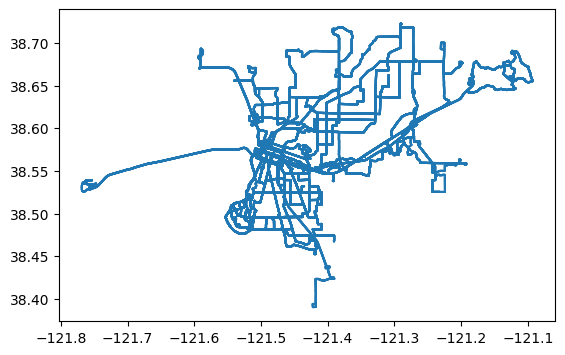

In [102]:
sac_m4m9.plot()

In [101]:
#uploading as geoparquet to GCS

utils.geoparquet_gcs_export(sac_m4m9, "gs://calitp-analytics-data/data-analyses/gtfs_schedule/", "sac_route_variance_m4m9_geo")

In [103]:
# attempt to read in dataframe from approach 2

sac_trip_desc = pd.read_parquet('gs://calitp-analytics-data/data-analyses/gtfs_schedule/sac_trips_route_identification_2023_m04_m09.parquet')

In [107]:
display(type(sac_trip_desc))
display(sac_trip_desc.shape)
list(sac_trip_desc.columns)

pandas.core.frame.DataFrame

(326, 8)

['feed_key',
 'name',
 'schedule_gtfs_dataset_key',
 'route_id',
 'route_short_name',
 'route_long_name',
 'route_desc',
 'month']

In [110]:
#comparing gtfs dataset keys
display(sac_m4m9.schedule_gtfs_dataset_key.value_counts())
display(sac_trip_desc.schedule_gtfs_dataset_key.value_counts())

#observed 1 dataset key in df1, but 2 dataset keys in df2


cb3074eb8b423dfc5acfeeb0de95eb82    1179
Name: schedule_gtfs_dataset_key, dtype: int64

43a1e46d592a1ee647bce8422c68460c    260
cb3074eb8b423dfc5acfeeb0de95eb82     66
Name: schedule_gtfs_dataset_key, dtype: int64

In [117]:
#comparing months
display(sac_m4m9.month.value_counts())
display(sac_trip_desc.month.value_counts())
#missing June 2023 from df2??

8    201
9    198
4    195
5    195
6    195
7    195
Name: month, dtype: int64

sep      66
april    65
may      65
july     65
aug      65
Name: month, dtype: int64

In [125]:
sac_trip_desc.groupby('month')

,feed_key,name,schedule_gtfs_dataset_key,route_id,route_short_name,route_long_name,route_desc,month
0,55c36112e9a6a849c0ddc65eb54de7f1,Sacramento Schedule,43a1e46d592a1ee647bce8422c68460c,001,1,GREENBACK,None,april
1,55c36112e9a6a849c0ddc65eb54de7f1,Sacramento Schedule,43a1e46d592a1ee647bce8422c68460c,011,11,NATOMAS/LAND PARK,None,april
2,55c36112e9a6a849c0ddc65eb54de7f1,Sacramento Schedule,43a1e46d592a1ee647bce8422c68460c,013,13,NATOMAS/ARDEN,None,april
3,55c36112e9a6a849c0ddc65eb54de7f1,Sacramento Schedule,43a1e46d592a1ee647bce8422c68460c,015,15,DEL PASO HEIGHTS,None,april
4,55c36112e9a6a849c0ddc65eb54de7f1,Sacramento Schedule,43a1e46d592a1ee647bce8422c68460c,019,19,RIO LINDA,None,april
...,...,...,...,...,...,...,...,...
61,294252b3b4b42fbb31a31ce184fcb3f5,Sacramento Schedule,cb3074eb8b423dfc5acfeeb0de95eb82,227,227,SOUTH LAND PARK - GREENHAVEN DR,None,sep
62,294252b3b4b42fbb31a31ce184fcb3f5,Sacramento Schedule,cb3074eb8b423dfc5acfeeb0de95eb82,228,228,GLORIA DR - RUSH RIVER DR,None,sep
63,294252b3b4b42fbb31a31ce184fcb3f5,Sacramento Schedule,cb3074eb8b423dfc5acfeeb0de95eb82,247,247,21ST ST - FLORIN RD,None,sep
64,294252b3b4b42fbb31a31ce184fcb3f5,Sacramento Schedule,cb3074eb8b423dfc5acfeeb0de95eb82,252,252,FREEPORT - FRUITRIDGE - ML KING,None,sep


# HALL OF SHAME

---


---


In [ ]:
#peaking into df to make sure everything looks good

#shape shows 11,927 rows and 8 columns
#display(df.shape)

#type shows data is in df
#display(type(df))

#columns return all the columns we listed in the function
#display(list(df.columns))

#value_counts confirm df only has rows from 2023 March to May
#display(df.value_counts(subset=['year','month']))

### via Tiffany, make df to GPD
* <b>COMPLETE</b> Query data from warehouse
* then use this snippet from `make_routes_gdf` from `_shared_utils/shared_utils/geography_utils.py`.
    * `ddf["geometry"] = ddf.pt_array.apply(make_linestring)`
<br>  
* <b>COMPLETE</b> then save out as geo parquet to the `gtfs_schedule` folder in GCS (so versioning and history stays) using 
    * `utils.geoparquet_gcs_export(vp_gdf, SEGMENT_GCS, f"vp_{analysis_date}")`

In [5]:
#test of make_routes_gdf. DO NOT RUN

# aprl_sept_2023_routes = geography_utils.make_routes_gdf(df, "EPSG:4326")

In [ ]:
#display(type(aprl_sept_2023_routes))
#list(aprl_sept_2023_routes.columns)
#display(aprl_sept_2023_routes.geometry.name)

---

In [6]:
#creating sub-df for 'Sacramento Schedule'. DO NOT RUN

# sac = aprl_sept_2023_routes[aprl_sept_2023_routes['name'] == 'Sacramento Schedule']

In [12]:
# type(sac)

geopandas.geodataframe.GeoDataFrame

In [13]:
#writing sac filtered gdf to gcs as geoparquet. DO NOT RUN AGAIN

# utils.geoparquet_gcs_export(sac, "gs://calitp-analytics-data/data-analyses/gtfs_schedule/", "sac_route_identification_2023_m04_m09_geo")

In [16]:
#Now we can read in the parquet file from gcs without having to remake everything again.

sac_gdf = gpd.read_parquet('gs://calitp-analytics-data/data-analyses/gtfs_schedule/sac_route_identification_2023_m04_m09_geo.parquet')

In [17]:
type(sac_gdf)

geopandas.geodataframe.GeoDataFrame

In [21]:
display(sac.shape)
display(sac.head())

(393, 8)

,key,source_record_id,name,route_id,shape_id,month,year,geometry
5,167599ffa2148995fe05ca3c6ab6f533,recbzZQUIdMmFvm1r,Sacramento Schedule,227,46061,8,2023,None
31,c15fc92307cee69b6c388a08d6cdbe5b,recbzZQUIdMmFvm1r,Sacramento Schedule,F10,46159,6,2023,"LINESTRING (-121.17992 38.67578, -121.18067 38..."
35,844f3b14e654ec1ffdbb1af2d486d29c,recbzZQUIdMmFvm1r,Sacramento Schedule,019,45281,5,2023,None
72,a0aa8f4292bed01247389a96f95d1176,recbzZQUIdMmFvm1r,Sacramento Schedule,068,46220,9,2023,"LINESTRING (-121.42656 38.59969, -121.42615 38..."
88,5ee089aa97106d962f283dd7d77fa8eb,recbzZQUIdMmFvm1r,Sacramento Schedule,013,45278,4,2023,"LINESTRING (-121.38163 38.60670, -121.38188 38..."


<AxesSubplot:>

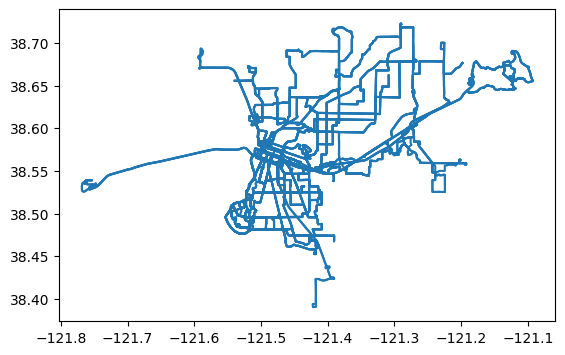

In [23]:
sac_gdf.plot()

In [ ]:
Attempt at creating sub df of each routes to plot

In [24]:
sac_routes = sac_gdf['route_id'].unique()


In [25]:
#empty dictionary
sac_sub_route_ids = {}

#each element in sac_routes will be called route.
#for each route in sac_routes, query each row related to that route.(where ever you use the variable route, go 1-by-1 the differnet
#then, create a dataframe for each route and place it into the dictionary sub_dataframes
for route in sac_routes:
    sub_df = sac[sac['route_id'] == route]
    sac_sub_route_ids[route] = sub_df

In [26]:
len(sac_sub_route_ids)

67

In [27]:
#testing dictionary with route 23 and 88
sac_sub_route_ids['023']

,key,source_record_id,name,route_id,shape_id,month,year,geometry
3217,f90f1ad42b05640b35bf145497eedaee,recbzZQUIdMmFvm1r,Sacramento Schedule,023,46184,9,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
11558,aaecd8ed8b3b2d9a02ca274610d5ea4c,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,7,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
16772,d04bc10c78b62fe6421c6eb28d509b78,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,8,2023,None
17098,d80d73174d1d318341a7af73a6fdc452,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45286,5,2023,None
20392,7f6cb56be4ebd83a3ec2e93e6a927d24,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,6,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
22640,1127c9acaecd57fd9543132998a72e3e,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45286,4,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."


In [ ]:
#function to plot routes and to check for any variation in route geometry
def route_checker(route_id):
    display(sac_sub_route_ids[route_id].plot())
    display(f'geometry checker...{sac_sub_route_ids[route_id].geometry.value_counts()}')
    

<AxesSubplot:>

'geometry checker...LINESTRING (-121.49172 38.57987, -121.49158 38...    4\nName: geometry, dtype: int64'

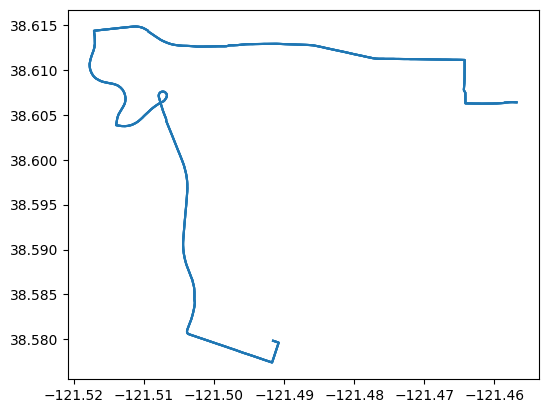

In [38]:
route_checker('088')

At this point determined we need more data that what `fct_monthly_routes` has. See approach 2

## Next Steps

for every `name` and `route_id` in routes, need to see if each row is the same or not. Need to identify any variation in the routes. 



---

Trying to use a loop that will create a df for every route_id in sac_routes. but would need to do this for every `name` in the `fct_monthly_routes` df eventually?


---

In [ ]:
#list of unique route names from initial df
route_names = df['name'].unique()


In [ ]:
#new loop that creates a dictionary of each unique schedule name with all its routes.
sub_route_name = {}

for name in route_names:
    sub_df2 = df[df['name'] == name]
    sub_route_name[name] = sub_df2
    

In [ ]:
#test to see if new dictionary works
sub_route_name['Auburn Schedule']

## Now I have `sac_sub_route_ids` and `sub_route_name` dictionaries

Examples of some noteable routes with slight variations over time.

In [ ]:
#General observations for Sacramento Schedule: 
#shape_id changes every month. 
#pt_array changes every month, however, did get a warning upon initial query of data so may need to review query to account for geodata
#Month 4 has the point geom data

display(sac_sub_route_ids['088'])
display(sac_sub_route_ids['023'])
display(sac_sub_route_ids['105'])
display(sac_sub_route_ids['F20'])
display(sac_sub_route_ids['215'])

In [ ]:
#test to see other route names
#other route names have more point geometry than Sacramento.
display(sub_route_name['Santa Cruz Schedule'])
display(sub_route_name['Merced Schedule'])
display(sub_route_name['San Diego Schedule'])
display(sub_route_name['Roseville Schedule'])

In [ ]:
import importlib

importlib.reload(segment_speed_utils)
from segment_speed_utils.project_vars import SCHED_GCS, analysis_date